# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
from part2 import process_corpus, build_vocab, CBOWBatcher, SkipGramBatcher

In [2]:
from part1 import reduce_to_k_dim, plot_embeddings

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/evlavrukhin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import torch
from torch import nn
from torch import optim
from torch.nn.init import kaiming_normal_

In [6]:
batcher = SkipGramBatcher(batch_size=256, window_size=5, shuffle=True)

In [7]:
%%time
corpus = process_corpus('text8')

CPU times: user 55.5 s, sys: 500 ms, total: 56 s
Wall time: 56 s


In [8]:
vocab = build_vocab(corpus, min_freq=5)

In [9]:
len(vocab)

71136

In [10]:
%%time
batcher.init(corpus, vocab)

CPU times: user 5.58 s, sys: 716 ms, total: 6.3 s
Wall time: 6.3 s


In [11]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size, device):
        super(CBOW, self).__init__()
        self.encode_layer = nn.Embedding(num_embeddings=vocab_size+1, 
                                         embedding_dim=hidden_size).to(device)
#         self.decode_layer = nn.Embedding(num_embeddings=vocab_size+1,
#                                          embedding_dim=hidden_size).to(device)
        self.decode_layer = nn.Linear(hidden_size, vocab_size+1, bias=False).to(device)
        self.encode_layer.weight.data = kaiming_normal_(self.encode_layer.weight.data)
        self.decode_layer.weight.data = kaiming_normal_(self.decode_layer.weight.data)
        
    def forward(self, x):
        context = self.encode_layer(x).mean(dim=1)
        activations = self.decode_layer(context)
        return activations

In [25]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, hidden_size, device):
        super(SkipGram, self).__init__()
        self.encode_layer = nn.Embedding(num_embeddings=vocab_size+1, 
                                         embedding_dim=hidden_size).to(device)
#         self.decode_layer = nn.Embedding(num_embeddings=vocab_size+1,
#                                          embedding_dim=hidden_size).to(device)
        self.decode_layer = nn.Linear(hidden_size, vocab_size+1, bias=False).to(device)
        self.encode_layer.weight.data = kaiming_normal_(self.encode_layer.weight.data)
        self.decode_layer.weight.data = kaiming_normal_(self.decode_layer.weight.data)
        
    def forward(self, x):
        context = self.encode_layer(x)
        activations = self.decode_layer(context)
        return activations

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [26]:
model = SkipGram(vocab_size=len(vocab), hidden_size=100, device=device)

In [27]:
optimizer = optim.SGD(params=model.parameters(),
                      lr=1e-2, momentum=0.9, weight_decay=1e-5)

In [16]:
# ones = torch.LongTensor(np.arange(len(vocab) + 1)).to(device)

In [28]:
CE_loss = nn.CrossEntropyLoss()

In [29]:
losses = []
for epoch in range(1):
    for i, (x, y) in tqdm(enumerate(batcher)):
        x_torch = torch.LongTensor(x).to(device)
        y_torch = torch.LongTensor(y).to(device)
        
        activations = model(x_torch)
        for i in range(y_torch.size(1)):
            loss = CE_loss(activations, y_torch[:, i])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(float(loss.cpu().data.numpy()))
        if (i + 1) % 1000 == 0:
            print(np.mean(losses[-100:]))
        break

0it [00:00, ?it/s]


In [30]:
loss

tensor(11.1899, device='cuda:0', grad_fn=<NllLossBackward>)

In [19]:
x_torch.shape, y_torch.shape

(torch.Size([256]), torch.Size([256, 10]))

In [20]:
self = model

In [21]:
context = self.encode_layer(x_torch)

In [22]:
context.shape

torch.Size([256, 100])

In [23]:
activations = self.decode_layer(context)

In [24]:
activations.shape

torch.Size([256, 71137])

In [26]:
def get_encode_emb(words, model, batcher):
    words_idx = [batcher.word2ind[word] for word in words]
    t = torch.LongTensor(words_idx).to(device)
    vectors = model.encode_layer(t).to('cpu').data.numpy()
    return vectors

def get_decode_emb(words, model, batcher):
    words_idx = [batcher.word2ind[word] for word in words]
    weights = model.decode_layer.weight.data
    vectors = weights[words_idx].to('cpu').data.numpy()
    return vectors

In [20]:
words = np.random.choice(vocab, size=200)

In [21]:
v = get_emb(words, model, batcher)

In [25]:
X = reduce_to_k_dim(v, k=2)

Running Truncated SVD over 200 words...
Done.


In [26]:
v.shape

(200, 100)

In [35]:
from scipy.spatial import KDTree

class Index:
    
    def __init__(self, model, vocab, batcher, get_emb):
        self.get_emb = get_emb
        embs = []
        self.idxes = []
        for word in vocab:
            vector = self.get_emb([word], model, batcher)
            vector = vector / np.linalg.norm(vector)
            embs.append(vector)
            self.idxes.append(batcher.word2ind[word])
        embs = np.concatenate(embs, axis=0)
        self.t = KDTree(embs)
        
        self.batcher = batcher
        self.model = model
        
    def most_similar(self, word, k=10):
        if isinstance(word, str):
            emb = self.get_emb([word], self.model, self.batcher)
        elif isinstance(word, np.ndarray):
            emb = word
        else:
            raise ValueError
        emb = (emb / np.linalg.norm(emb)).flatten()
        dists, idxes = self.t.query(emb, k)
        return [(self.batcher.ind2word[self.idxes[i]], 1 - d / 2) for i, d in zip(idxes, dists)]

In [36]:
%%time
idx1 = Index(model, vocab, batcher, get_encode_emb)

CPU times: user 4.18 s, sys: 116 ms, total: 4.29 s
Wall time: 4.29 s


In [29]:
%%time
idx2 = Index(model, vocab, batcher, get_decode_emb)

CPU times: user 4.11 s, sys: 121 ms, total: 4.23 s
Wall time: 4.23 s


In [30]:
idx1.most_similar('man', k=20)

[('man', 1.0),
 ('synchronisation', 0.4725376403823245),
 ('blizzard', 0.45523560314461875),
 ('fries', 0.44976747399656647),
 ('enforced', 0.4473744422002508),
 ('gli', 0.44644988173530087),
 ('lavos', 0.4443694595767622),
 ('yielded', 0.4357759353097811),
 ('heraclius', 0.43245498428248097),
 ('scout', 0.429483110656125),
 ('lemma', 0.4292389791352129),
 ('mycenean', 0.42915058587906163),
 ('irregular', 0.4284171053112301),
 ('bpm', 0.42808225614269446),
 ('scanner', 0.42775674284295007),
 ('archaea', 0.4273466831089835),
 ('kinder', 0.4273061954587616),
 ('fontana', 0.4267526136175912),
 ('fooled', 0.4253602306279918),
 ('callisto', 0.4252159928604854)]

In [31]:
idx2.most_similar('man', k=20)

[('man', 1.0),
 ('irish', 0.6858699871148994),
 ('period', 0.6808081085592322),
 ('following', 0.6740259210625159),
 ('russian', 0.6723703422113378),
 ('japan', 0.6720524541140878),
 ('held', 0.6692312231780294),
 ('constitution', 0.6630763290227405),
 ('special', 0.6625821880347609),
 ('took', 0.6619371952101278),
 ('paul', 0.6618528402789028),
 ('magazine', 0.6617515341983129),
 ('book', 0.660938890082049),
 ('began', 0.6609283756130216),
 ('story', 0.6598270848422293),
 ('france', 0.65965819407069),
 ('film', 0.6585066699083151),
 ('major', 0.6548955573215393),
 ('death', 0.653863026065268),
 ('page', 0.653095425758186)]

In [32]:
get_emb = lambda word: get_encode_emb([word], model, batcher)

In [33]:
v = get_emb('woman') + get_emb('king') - get_emb('man')

In [37]:
idx1.most_similar(v)

[('woman', 0.527854044183755),
 ('king', 0.5101529165621685),
 ('determinants', 0.4723300671057018),
 ('developers', 0.4584093361158289),
 ('trask', 0.4421576104572045),
 ('satisfy', 0.4397980425341457),
 ('pressed', 0.43594519601931225),
 ('remembrance', 0.43094093420152624),
 ('vcrs', 0.42905244519798813),
 ('rusting', 0.4284009682142984)]

In [39]:
from gensim.models.word2vec import Word2Vec

In [41]:
idx2.most_similar('car')

[('car', 1.0),
 ('note', 0.6483254293415512),
 ('view', 0.6460626072722943),
 ('established', 0.6357027949548),
 ('way', 0.6321196700795595),
 ('little', 0.6305343403868436),
 ('story', 0.6292587750059208),
 ('held', 0.6282311206255103),
 ('according', 0.6281906001466642),
 ('back', 0.62761703371167)]

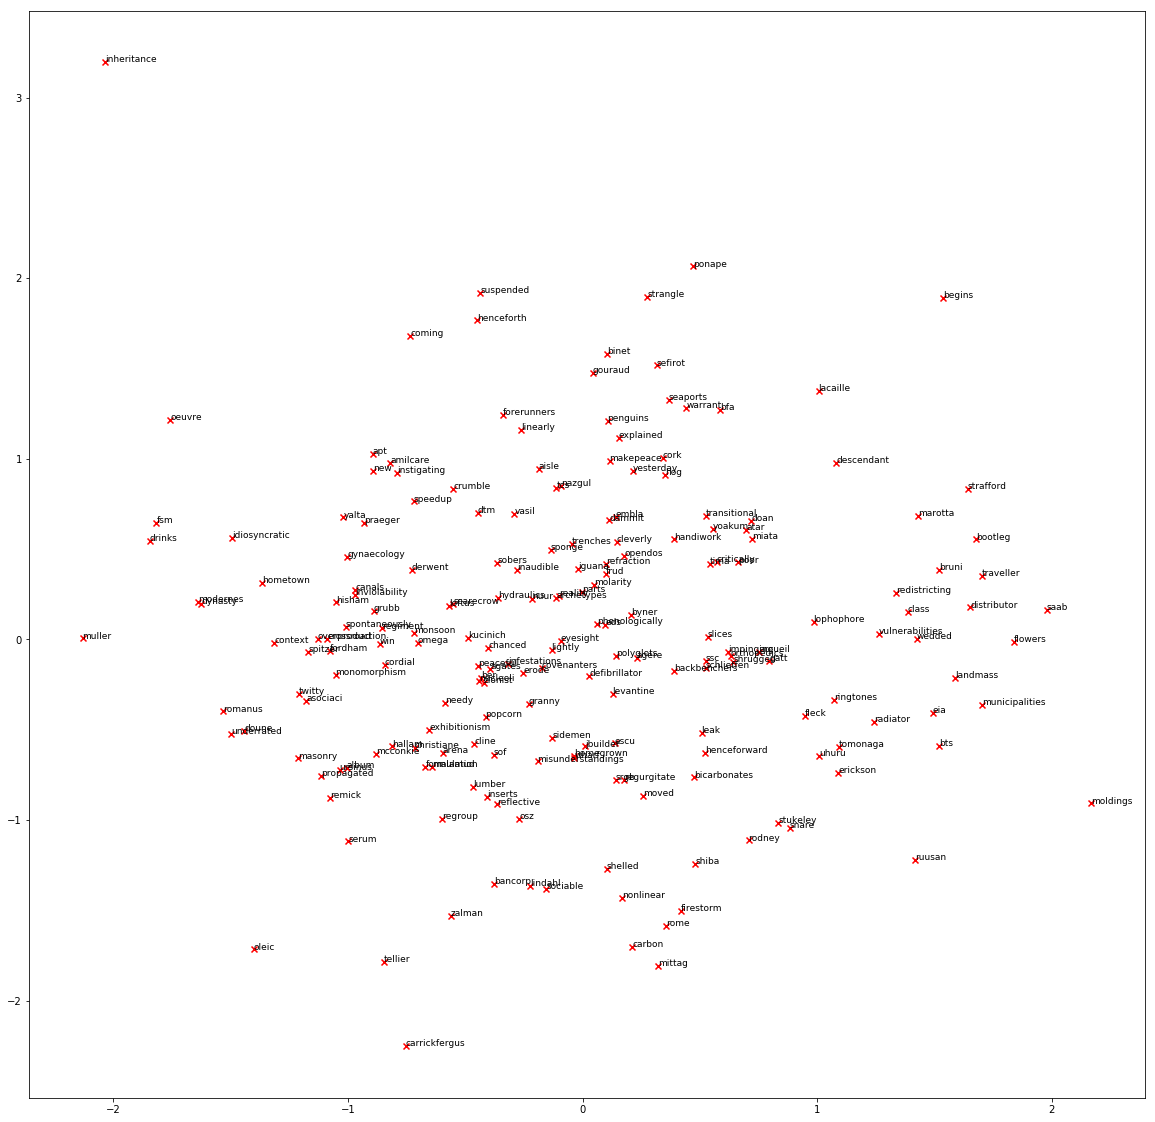

In [27]:
plot_embeddings(X, batcher.word2ind, words)

In [114]:
p = batcher.transform([sent])

In [115]:
batcher.inverse_transform(p)

[['emotional',
  'reciprocity',
  'qualitative',
  'impairments',
  'in',
  'communication',
  'as',
  'manifested',
  'by',
  'at',
  'least',
  'one',
  'of',
  'the',
  'following',
  'delay',
  'in',
  'or',
  'total',
  'lack']]

In [110]:
sent = corpus[0][10000:10020]

In [112]:
sent

['emotional',
 'reciprocity',
 'qualitative',
 'impairments',
 'in',
 'communication',
 'as',
 'manifested',
 'by',
 'at',
 'least',
 'one',
 'of',
 'the',
 'following',
 'delay',
 'in',
 'or',
 'total',
 'lack']

In [22]:
np.mean(losses[len(losses) * 9 // 10 : ])

6.056174871291402

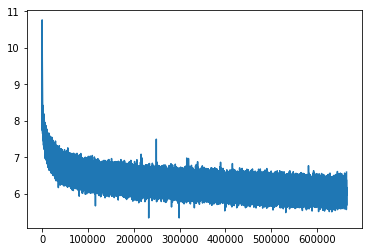

In [23]:
# lr 1e-2
plt.plot(losses)
plt.show()

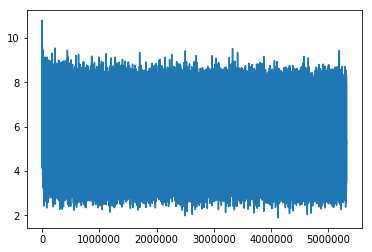

In [20]:
# lr 1e-2
plt.plot(losses)
plt.show()

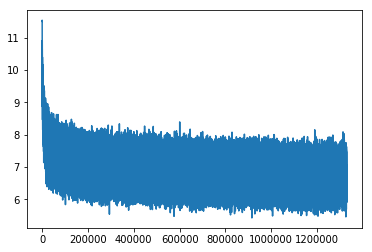

In [16]:
# lr 1e-1
plt.plot(losses)
plt.show()

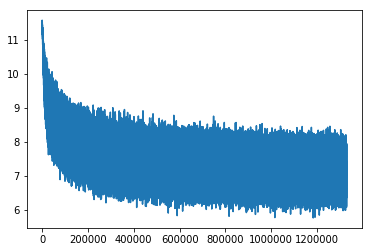

In [17]:
# lr 1e-2
plt.plot(losses)
plt.show()

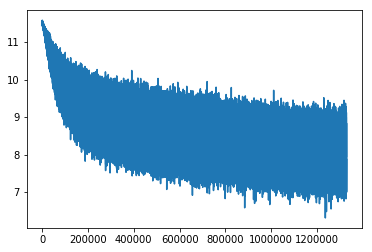

In [22]:
# lr 1e-3
plt.plot(l)
plt.show()